# 보팅 앙상블

단일 모델을 앙상블하여 더 나은 예측을 하는 앙상블 모델을 만들어본다

In [1]:
from sklearn import datasets
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 손글씨 데이터 로드

In [2]:
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)

## 단일 모델의 정확도 측정

의사결정트리, knn, svm 모델의 정확도를 측정한다.

In [3]:
dtree = tree.DecisionTreeClassifier(criterion='gini', max_depth=8, max_features=32, random_state=35)
dtree = dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

svm = SVC(C=0.1, gamma=0.003, probability=True, random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)

In [4]:
print('[accuracy]')
print('d-tree: ', accuracy_score(y_test, dtree_predicted))
print('knn   : ', accuracy_score(y_test, knn_predicted))
print('svm.  : ', accuracy_score(y_test, svm_predicted))

[accuracy]
d-tree:  0.7611111111111111
knn   :  0.8083333333333333
svm.  :  0.8194444444444444


## 분류값별 확률 확인
소프트 보팅 또는 하드 보팅은 사이킷런의 voting classifier를 사용해 쉽게 구현할 수 있다.  
직접 소프트 보팅을 구현할 때는 predict_proba 함수를 사용하여 테스트 수행 시 측정된 분류값 별 확률을 사용하면 된다. 

아래는 SVM으로부터 나온 테스트 데이터 2개의 0부터 9까지의 확률을 볼 수 있다.

In [6]:
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2])

[[0.00730732 0.03188592 0.63987215 0.01744391 0.0230208  0.0193824
  0.00798126 0.01694527 0.20453521 0.03162577]
 [0.00229853 0.00562826 0.0068469  0.00285671 0.89548869 0.00403142
  0.00206652 0.0090767  0.06374138 0.00796489]]


### 하드보팅
하드 보팅은 일반적으로 투표와 같이, 각각의 분류기의 예측값들을 모아 가장 많은 득표를 받은 예측값으로 최종 결론을 내는 방식이다.

In [7]:
voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dtree), ('knn', knn), ('svm', svm)],
    weights=[1,1,1], voting='hard').fit(X_train, y_train)

hard_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, hard_voting_predicted)

0.8611111111111112

### 소프트보팅
소프트 보팅은 각 분류모델의 predicted_proba를 활용해 모든 분류값들의 확률을 더해서 가장 높은 점수를 획득한 분류값으로 최종 결론을 내리는 방식이다

In [8]:
voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dtree), ('knn', knn), ('svm', svm)],
    weights=[1,1,1], voting='soft').fit(X_train, y_train)

soft_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, soft_voting_predicted)

0.8583333333333333

## 단일 모델과 앙상블 모델의 정확도 비교 시각화

정확도를 히스토그램으로 시각화한다.

([<matplotlib.axis.XTick at 0x7f9bacea20f0>,
 [Text(0, 0, 'decision tree'),
  Text(1, 0, 'knn'),
  Text(2, 0, 'svm'),
  Text(3, 0, 'hard voting'),
  Text(4, 0, 'soft voting')])

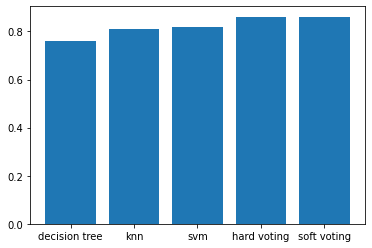

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)
plt.bar(x, height = [accuracy_score(y_test, dtree_predicted),
                     accuracy_score(y_test, knn_predicted),
                     accuracy_score(y_test, svm_predicted),
                     accuracy_score(y_test, hard_voting_predicted),
                     accuracy_score(y_test, soft_voting_predicted)])

plt.xticks(x, ['decision tree', 'knn', 'svm', 'hard voting', 'soft voting'])

In [ ]:
하드보팅과 소프트보팅 앙상블의 결과가 다른 모델들보다 높은 것을 확인할 수 있다. 하지만 때로는 단일 모델이 더 나은 정확도를 보일 때도 있다.  
알려지지 않은 데이터를 예측해야 하는 분